# OBJECT DETECTION (CLASSIFICATION + LOCALIZATION) ON CUSTOM DATA


This notebook trains a model that detects an object from an image and creates a rectangular bounding box around it with a label and confidence score. "Classification" means classifying the image with a label and "Localization" means detecting the objects position in the image. The model is a classifier plus regressor. Classifier detects the class and Regressor detects the bounding box coordinates which is a continuous number.

****

**DATASET** - Dataset contains two folders images and annotations. 

>>images folder contains all the images of Indian currencies. I have manually collected all the images from the internet. Total 414 images are there with some duplicates, which is very less. 

>>annotations folder contains all the xml file of the images that contains the information about the images like width, height, label and bounding box coordinates. I have used "LabelImg" annotation tool to label them. I have used PASCAL VOC format to save them (i.e. xml). *Labelling images is a time intensive* 

****
**TOTAL IMAGES** - 414 (Indian Currencies)
****
**CLASSES** - 7 classes (Rs. 10, 20, 50, 100, 200, 500 & 2000)
****
**MODEL** - Residual Network (ResNet34) 
****
**MODE OF TRAINING** - Transfer Learning
****
**LIBRARY** - PyTorch, OpenCV, scikit-learn
****

In [1]:
#library imports
import os
import random
import math
import pandas as pd
import numpy as np

import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models

### HELPER FUNCTIONS

Following are the various functions that we need :-
****
**read_image(path)** - Read images from the given path into colored format as opencv opens in grayscale
****
**create_image_list(image_path)** - Iterates through the images folder and create a list of all the images.
****

In [2]:
# READ IMAGES IN COLORED FORMAT
def read_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

# CREATE IMAGE LIST
def create_image_list(image_path):
    image_list = []
    # ITERATE THROUGH IMAGES FOLDER
    for image in os.listdir(image_path):
        # APPEND THE NAME OF IMAGES TO THE LIST
        image_list.append(image)
    return image_list

****
**image_resize(image_path, new_path, bb, size)** - It resizes the image as all the images should of be of same size.
****
When we resize the image, its bounding box should also be resized. For that we have to make a mask(filled rectangle) from the rectangular coordinates i.e. we will make everything black and area surrounded by the bounding box white. Then resize that mask and convert it again into empty rectangular shape (bounding box). Don't worry if you didn't get it, following cells will clarify the things.
****
**create_mask(bb, image)** - create mask from the image and bounding box.
****
**convert_to_bb(mask)** - convert mask to bounding box 
****
**plot_bb(path, bb)** - plot image with bounding box, path is the image path.
****

In [3]:
# CREATE MASK FOR BOUNDING BOX
def create_mask(bb, image):
    # EXTRACT THE IMAGE SHAPE
    rows,cols,*_ = image.shape
    # CREATE A MATRIX OF ZERO OF THE IMAGE SHAPE
    mask = np.zeros((rows, cols))
    # FILL THE MATRIX CONTAINING THE BOUNDING BOX WITH VALUE 1
    mask[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return mask

# CONVERT RESIZED MASK TO BOUNDING BOX
def convert_to_bb(mask):
    # EXTRACT THE SHAPE OF THE MASK OF BOUNDING BOX CREATED
    cols, rows = np.nonzero(mask)
    # RETURN ZERO COORDINATES IF NO MASK
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    # EXTRACT THE BOUNDING BOX COORDINATES
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

# RESIZE THE IMAGES AND SAVE IT IN ANOTHER FOLDER
def image_resize(image_path, new_path, bb, size):
    # READ THE IMAGE FILE
    image = read_image(image_path)
    # RESIZE THE IMAGE
    image_resized = cv2.resize(image, (int(1.49*size), size))
    # CREATE MASK FROM THE BOUNDING BOX
    mask = create_mask(bb, image)
    # RESIZE THE MASK 
    mask_resized = cv2.resize(mask, (int(1.49*size), size))
    # WRITE THE NEW IMAGE INTO ANOTHER FOLDER
    cv2.imwrite(new_path, cv2.cvtColor(image_resized, cv2.COLOR_RGB2BGR))
    return new_path, convert_to_bb(mask_resized)

# PLOT THE BOUNDING BOX AROUND THE IMAGE
def plot_bb(path, bb):
    image = read_image(path)
    # CONVERT BOUNDING BOXES (BB) INTO FLOAT
    bb = np.array(bb, dtype=np.float32)
    # CREATE A RECTANGLE FROM THE BB
    rect_box = plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color='red',
                         fill=False, lw=3)
    # RENDER THE IMAGE
    plt.imshow(image)
    # APPLY THE BB TO THE CURRENT AXIS RENDERING IMAGE
    plt.gca().add_patch(rect_box)

### ALERT !!! Following code will run after you create dataframe, run next to next cells first to create dataset. I have created this cell for demo purpose.

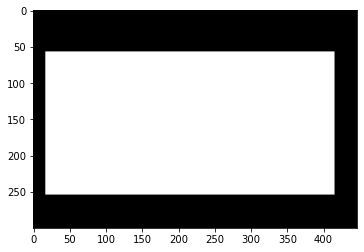

In [11]:
image = read_image(dataframe['filename'][360])
bb = np.array(dataframe['bb'][360], dtype=np.int32)
mask = create_mask(bb, image)
plt.imshow(mask, cmap='gray')

This is the mask created from the bounding box that I referred in the above cell. Then later we can resize this white patch to the scale of the resized image and convert it again into bounding box.

****
**extract_bb()** - It will iterate through the xml files and extract bounding box coordinates from it. 
****
**generate_dataframe()** - it will generate dataframe with columns "filename",*(image_path)*, "bb",*(bounding-box)*, and "class_name",*(label)*
****

In [4]:
# EXTRACT BOUNDING BOX FROM THE ANNOTATION FILE
def extract_bb(anno_path):
    # PARSE THE XML FILE TO EXTRACT BB COORDINATES AND CLASS_NAME
    root = ET.parse(anno_path).getroot()
    class_name = root.find("./object/name").text
    xmin = int(root.find("./object/bndbox/xmin").text)
    ymin = int(root.find("./object/bndbox/ymin").text)
    xmax = int(root.find("./object/bndbox/xmax").text)
    ymax = int(root.find("./object/bndbox/ymax").text)
    # RETURN BOUNDING BOX COORDINATES
    bb = [ymin, xmin, ymax, xmax]
    return bb, class_name

# GENERATE DATAFRAME
def generate_dataframe(image_list, anno_path, image_path, new_path, size):
    dataset = []
    for image in image_list:
        path = image_path + image
        a_path = anno_path + image.split('.')[0] + '.xml'
        # EXTRACT BB AND CLASS_NAME FROM ANNOTATION FILE
        bb, class_name = extract_bb(a_path)
        # FILENAME OF THE NEW RESIZED IMAGE
        n_path = new_path + image 
        # RESIZE THE IMAGE AND CORRESPONDING BOUNDING BOX 
        img_path, resized_bb = image_resize(path, n_path, bb, size)
        # APPEND EVERYTHING TO A DICTIONARY 
        data = dict()
        data['filename'] = img_path
        data['bb'] = resized_bb
        data['class_name'] = class_name
        # APPEND THE DICTIONARY TO THE LIST
        dataset.append(data)
    # APPEND THE LIST TO THE DATAFRAME 
    return pd.DataFrame(dataset) 

****
**normalize_image()** - it normalizes the image pixels to imagenet format by subtracting mean and dividing by standard deviation because ResNet is trained on ImageNet dataset.
****
**scale_image()** - it scales the image pixels into same range
****
**train_model()** - trains the model caluclates the loss, gradients, backpropagates the loss and update the weights.
****
**calculate_validation_metrics()** - calculates the validation loss and accuracy
****

In [17]:
# NORMALIZE THE IMAGE PIXELS TO MATCH IMAGE_NET STATS
def normalize_image(image):
    # IMAGENET STATS 
    stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (image - stats[0])/stats[1] 

# SCALE THE IMAGE PIXELS
def scale_image(path):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    return x

# TRAIN THE MODEL 
def train_model(model, optimizer, train_dl, val_dl, epochs, C=1000):
    idx = 0
    # ITERATE THROUGH EPOCHS
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        # ITERATE THROUGH THE TENSORS
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            # IMAGE PIXELS TENSOR
            x = x.cuda().float()
            # CLASS TENSORS
            y_class = y_class.cuda()
            # BB TENSORS
            y_bb = y_bb.cuda().float()
            # LOAD THE TENSORS INTO MODEL AND PREDICT THE CLASS_NAMES AND BB
            out_class, out_bb = model(x)
            # CALCULATE LOSS BETWEEN THE ACTUAL & PREDICTED CLASS 
            loss_class = torch.nn.functional.cross_entropy(out_class, y_class, reduction="sum")
            # CALCULATE LOSS BETWEEN THE ACTUAL & PREDICTED BB COORDINATES
            loss_bb = torch.nn.functional.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            # ADD THE 4 BB LOSSES INTO A SINGLE VALUE
            loss_bb = loss_bb.sum()
            # SCALE THE BB LOSS BY 1000 TO HAVE CLASS LOSS AND BB LOSS IN SAME RANGE
            loss = loss_class + loss_bb/C
            # SET GRADIENTS TO ZERO
            optimizer.zero_grad()
            # BACKPROPOGATE THE LOSS
            loss.backward()
            # UPDATE ALL PARAMETERS
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        # CALCULATE THE TOTAL TRAINING LOSS
        train_loss = sum_loss/total
        # CALCULATE THE VALIDATION LOSS AND ACCURACY
        val_loss, val_acc = calculate_validation_metrics(model, valid_dl, C)
        print("epoch %d train_loss %.3f val_loss %.3f val_acc %.3f" % (i, train_loss, val_loss, val_acc))
    return sum_loss/total

# FOR CALCULATING VALIDATION LOSS AND ACCURACY
def calculate_validation_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = torch.nn.functional.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = torch.nn.functional.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

****
**Currency()** - Currency is the name of the class that inherits the property of Dataset (torch) required for loading into the PyTorch model.
****
**ResNetModel()** - creates architecture for the model, it outputs two outputs, probability distribution of classlabels and 4 float values representing bounding box values.
****

In [ ]:
# PREPARE THE DATASET TO PASS THROUGH MODEL
class Currency(Dataset):
    def __init__(self, paths, bb, y):
        self.paths = paths.values
        self.bb = bb.values
        self.y = y

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index]
        y_class = self.y[index]
        y_bb = self.bb[index]
        x = scale_image(path)
        x = normalize_image(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

# DEFINE MODEL ARCHITECTURE
class ResNetModel(torch.nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = torch.nn.Sequential(*layers[:6])
        self.features2 = torch.nn.Sequential(*layers[6:])
        self.classifier = torch.nn.Sequential(torch.nn.BatchNorm1d(512), torch.nn.Linear(512, 7))
        self.bb = torch.nn.Sequential(torch.nn.BatchNorm1d(512), torch.nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        y_class = torch.nn.functional.softmax(self.classifier(x), dim=1)
        return y_class, self.bb(x)

### CREATE DATASET

In [6]:
# CREATE NEW FOLDER
!mkdir resized_image

In [7]:
image_path = '../input/currency-datasets/images/'
anno_path =  '../input/currency-datasets/annotations/'
new_path = './resized_image/'

# CREATE IMAGE LIST
image_list = create_image_list(image_path)
# SHUFFLE THE LIST
np.random.shuffle(image_list)

image_list[:5]

['10_29 (copy).jpeg', '10_9.jpeg', '50_38.jpeg', '2000_2.jpeg', '200_42.jpeg']

In [9]:
# CREATE DATAFRAME
dataframe = generate_dataframe(image_list, anno_path, image_path, new_path, 300)

X = dataframe[['filename', 'bb']]
Y = dataframe['class_name']

# ENCODE THE CLASS NAMES
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# SPLIT INTO TRAIN AND VALIDATION SETS
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

# CREATE DATASETS
train_ds = Currency(x_train['filename'],x_train['bb'] ,y_train)
valid_ds = Currency(x_val['filename'],x_val['bb'],y_val)

# PREPARE THE BATCH OF TRAINING AND VALIDATION TO LOAD
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [10]:
dataframe.head()

,filename,bb,class_name
0,./resized_image/10_29 (copy).jpeg,"[84.0, 36.0, 139.0, 362.0]",ten
1,./resized_image/10_9.jpeg,"[66.0, 22.0, 263.0, 389.0]",ten
2,./resized_image/50_38.jpeg,"[6.0, 132.0, 185.0, 353.0]",fifty
3,./resized_image/2000_2.jpeg,"[20.0, 38.0, 136.0, 393.0]",twoThousand
4,./resized_image/200_42.jpeg,"[38.0, 89.0, 158.0, 356.0]",twoHundred


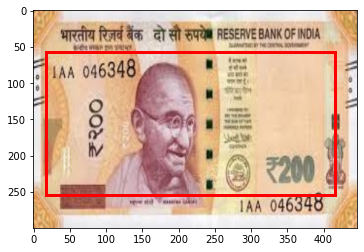

In [12]:
plot_bb(dataframe['filename'][360], dataframe['bb'][360])

In [13]:
# 0:50 1:500 2:100 3:10 4:20 5:200 6:2000
label_encoder.inverse_transform([0,1,2,3,4,5,6])

array(['fifty', 'fiveHundred', 'hundred', 'ten', 'twenty', 'twoHundred',
       'twoThousand'], dtype=object)

## TRAIN THE MODEL

In [18]:
# CALL MODEL AND SET PARAMETERS
res_model = ResNetModel().cuda()
parameters = filter(lambda param: param.requires_grad, res_model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)

train_model(res_model, optimizer, train_dl, valid_dl, epochs=200)

epoch 0 train_loss 2.137 val_loss 2.631 val_acc 0.213
epoch 1 train_loss 1.927 val_loss 2.579 val_acc 0.225
epoch 2 train_loss 1.916 val_loss 2.520 val_acc 0.270
epoch 3 train_loss 1.911 val_loss 2.257 val_acc 0.562
epoch 4 train_loss 1.878 val_loss 2.144 val_acc 0.708
epoch 5 train_loss 1.883 val_loss 1.994 val_acc 0.843
epoch 6 train_loss 1.878 val_loss 2.048 val_acc 0.809
epoch 7 train_loss 1.867 val_loss 1.988 val_acc 0.843
epoch 8 train_loss 1.869 val_loss 2.061 val_acc 0.787
epoch 9 train_loss 1.869 val_loss 2.097 val_acc 0.708
epoch 10 train_loss 1.862 val_loss 2.113 val_acc 0.685
epoch 11 train_loss 1.866 val_loss 2.014 val_acc 0.809
epoch 12 train_loss 1.858 val_loss 1.950 val_acc 0.876
epoch 13 train_loss 1.854 val_loss 1.931 val_acc 0.899
epoch 14 train_loss 1.867 val_loss 2.150 val_acc 0.663
epoch 15 train_loss 1.855 val_loss 1.993 val_acc 0.820
epoch 16 train_loss 1.826 val_loss 1.948 val_acc 0.843
epoch 17 train_loss 1.818 val_loss 1.922 val_acc 0.899
epoch 18 train_loss 

epoch 149 train_loss 1.210 val_loss 1.323 val_acc 0.921
epoch 150 train_loss 1.208 val_loss 1.323 val_acc 0.921
epoch 151 train_loss 1.208 val_loss 1.324 val_acc 0.921
epoch 152 train_loss 1.212 val_loss 1.328 val_acc 0.921
epoch 153 train_loss 1.207 val_loss 1.322 val_acc 0.921
epoch 154 train_loss 1.208 val_loss 1.325 val_acc 0.933
epoch 155 train_loss 1.212 val_loss 1.325 val_acc 0.921
epoch 156 train_loss 1.210 val_loss 1.318 val_acc 0.921
epoch 157 train_loss 1.204 val_loss 1.318 val_acc 0.921
epoch 158 train_loss 1.209 val_loss 1.327 val_acc 0.910
epoch 159 train_loss 1.207 val_loss 1.322 val_acc 0.921
epoch 160 train_loss 1.209 val_loss 1.322 val_acc 0.921
epoch 161 train_loss 1.206 val_loss 1.320 val_acc 0.921
epoch 162 train_loss 1.213 val_loss 1.318 val_acc 0.921
epoch 163 train_loss 1.206 val_loss 1.322 val_acc 0.921
epoch 164 train_loss 1.206 val_loss 1.317 val_acc 0.921
epoch 165 train_loss 1.208 val_loss 1.317 val_acc 0.921
epoch 166 train_loss 1.204 val_loss 1.319 val_ac

1.2085785323923284

## EVALUATE THE MODEL

Following code snippet tests the model

In [21]:
test_image = '500_1.jpeg'

# PREPARE THE DATA TO LOAD
test_ds = Currency(pd.DataFrame([{'path':'./resized_image/{}'.format(test_image)}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

# CONVERT IT INTO TENSOR
xx = torch.FloatTensor(x[None,])

# PASS THE TENSOR TO THE MODEL
out_class, out_bb = res_model(xx.cuda())
out_class, out_bb

(tensor([[1.4133e-10, 1.0000e+00, 1.5123e-08, 2.1545e-09, 1.2847e-09, 1.8769e-10,
          1.1192e-09]], device='cuda:0', grad_fn=<SoftmaxBackward>),
 tensor([[ 46.8450,  28.4949, 256.0421, 414.9444]], device='cuda:0',
        grad_fn=<AddmmBackward>))

****
**out_class**  - array with 7 values showing probablities of falling into 7 classes, choose the maximum probability. These values are also known as "confidence score"
****
**out_bb**  - array with 4 values showing the coordinates of the bounding box i.e. ( ymin, xmin, ymax, xmax)
****

## INFERENCE CODE 

**identify_currency()** - A function in which you can pass the path of the image and it will output the class_label, confidence score in the 

format "50Rs:0.99" 50Rs is the class of the image and 0.99 is the confidence score representing 99% assurity of image being Rs.50 with 

bounding box drawn around the image. 

In [23]:
currency_map = {0:'50Rs', 1:'500Rs', 2:'100Rs', 3:'10Rs', 4:'20Rs', 5:'200Rs', 6:'2000Rs'}

def identify_currency(image_path):

    im = read_image(image_path)
    test_ds = Currency(pd.DataFrame([{'path':'{}'.format(image_path)}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
    x, y_class, y_bb = test_ds[0]
    xx = torch.FloatTensor(x[None,])
    out_class, out_bb = res_model(xx.cuda())
    index = out_class.cpu().data.numpy().argmax()
    confidence = out_class.cpu().data.numpy()[0][index]

    bb_hat = out_bb.detach().cpu().numpy()
    bb_hat = abs(bb_hat)
    plot_bb(image_path, bb_hat[0])
    output = '{}:{}'.format(currency_map[index], confidence)
    print(output)

500Rs:1.0


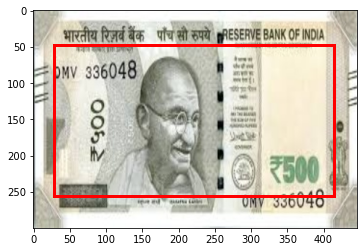

In [24]:
test_image = '500_1.jpeg'
img_path = './resized_image/{}'.format(test_image)
identify_currency(img_path)

10Rs:0.9999871253967285


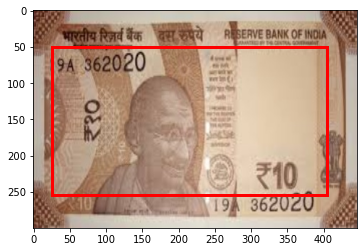

In [25]:
test_image = '10_1.jpeg'
img_path = './resized_image/{}'.format(test_image)
identify_currency(img_path)

50Rs:0.9999973773956299


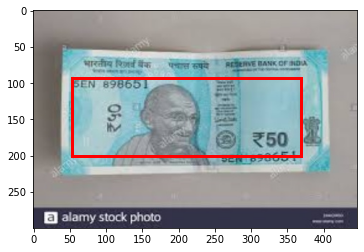

In [27]:
test_image = '50_10.jpeg'
img_path = './resized_image/{}'.format(test_image)
identify_currency(img_path)

200Rs:0.9999995231628418


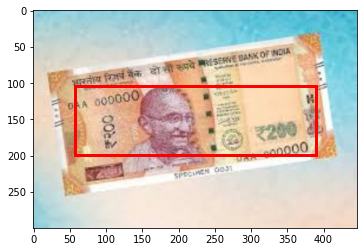

In [28]:
test_image = '200_10.jpeg'
img_path = './resized_image/{}'.format(test_image)
identify_currency(img_path)

20Rs:0.9999967813491821


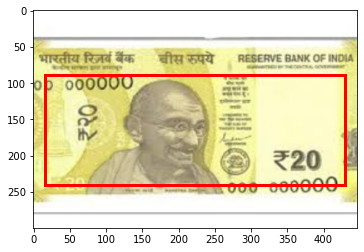

In [26]:
test_image = '20_1.jpeg'
img_path = './resized_image/{}'.format(test_image)
identify_currency(img_path)

2000Rs:0.9998996257781982


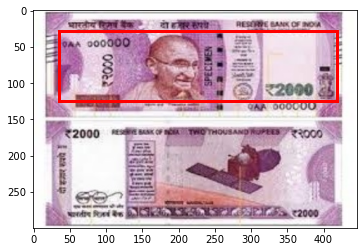

In [29]:
test_image = '2000_55.jpeg'
img_path = './resized_image/{}'.format(test_image)
identify_currency(img_path)

100Rs:0.9999157190322876


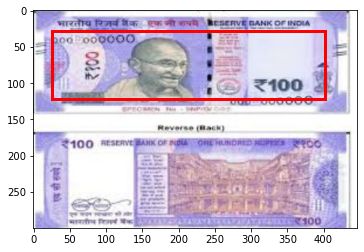

In [31]:
test_image = '100_23.jpeg'
img_path = './resized_image/{}'.format(test_image)
identify_currency(img_path)

## SAVE YOUR MODEL AND USE IT FOR LATER PURPOSES.

In [ ]:
torch.save(res_model, 'new_res_model.pth')

## ERRORS

You might get following errors :-

**AssertionError: Torch not compiled with CUDA enabled**  - Enable your GPU then.

**RuntimeError: CUDA error: device-side assert triggered** - Refer to this, I have answered there https://stackoverflow.com/a/64156344/7850174

After any of the CUDA error, restart the notebook, otherwise you will keep on getting the CUDA error because the earlier assertion hasn't been flushed out. By restarting the notebook, you will flush out all the cuda assertions. 

## CONCLUSION


I know its not that perfect because the model has been trained only 400 images which are very very less. Also I have tested the model on the same images on which I have trained it.

If you have a dataset with atleast 10,000 images, then your model will be very good. Also you can use other models like Xception, VGG or can make your own architecture. Try to train it on epochs not less than 100. 

If you are someone who didn't manage to configure YOLO or TensorFlow Object Detection API for custom dataset training (like me :) then remember this is for you. I invested my 4 days on making this model as I am beginner into this field and I am really glad that I did it. This is my very first Object detection model and for the very first time I used PyTorch also. 


If you want to download this pretrained model use it on your images (Indian Currency) clicked by you , click on the link below

MODEL LINK - https://drive.google.com/drive/u/1/folders/1VP9KRs4np64AMctirHPjvtu2Am7tKwRa

#### HAPPY LEARNING!!!